# Supercritical pitchfork bifurcation of Euler's column

***

This notebook shows the reproduction of the supercritical pitchfork bifurcation of Euler's column with MSC Nastran SOL 106. After having assessed different buckling calculation methods in the [last notebook](01_Buckling_Analysis_Euler_Column.ipynb), now we want to test the nonlinear capabilities of SOL 106 reproducing the known behavior of Euler's column. We first recall the analytical results for a 1 DOF system and then we move on to the numerical computations. Different methods and load case sequences are investigated to move along the branches of Euler's column equilibrium diagram.

* [1 DOF system](#1dof)
* [Setup of the numerical model](#numerical-model)
* [Load case sequence definition](#subcases-definition)
* [Full Newton method](#newton)
* [Arc-length method](#arc-length)
    * [Investigation of equilibrium paths around $P_x/P_{cr}=2](#pxpcr2-investigation)
    * [Reduced compression force](#reduced-compression)
* [Final supercritical pitchfork bifurcation analysis](#final)
* [Conclusions](#conclusions)

## 1 DOF system <a name="1dof"></a>

***

Let's take the 1 DOF system represented below, composed by two initially collinear rods with a linear torsional spring under axial compressive load $P$.

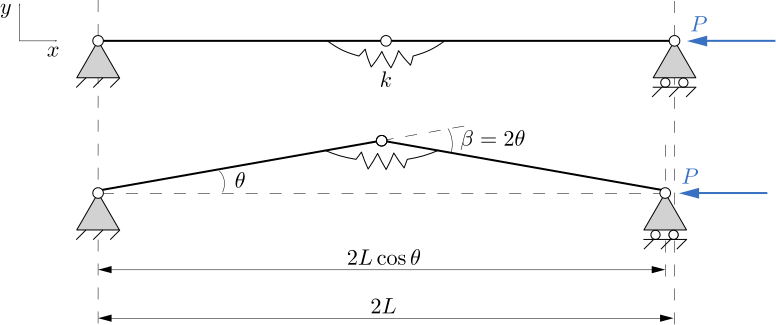

In [1]:
from IPython.display import SVG  # class to embed an SVG into the display
import os  # module with miscellaneous operating system interfaces
SVG(filename=os.path.join('resources', '02_CollinearRods.svg'))

The equilibrium equation is satisfied under two conditions:
$$\theta=0$$
$$\frac{P}{P_{cr}}=\frac{\theta}{\sin\theta}$$
where $\theta=0$ is the trivial solution and $P_{cr}=2k/L$ is the buckling load.

For $\theta=0$ the equilibrium is stable for $P<P_{cr}$, while for $P/P_{cr}=\theta/\sin\theta$ the equilibrium is always stable.

If we add an imperfection to the system, such as the initial angle $\theta_0$ shown below, the equilibrium changes.

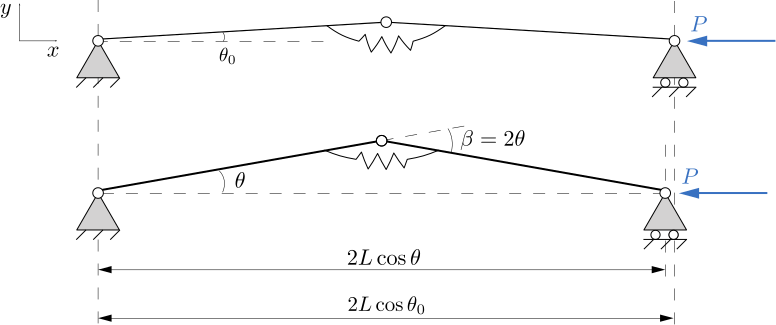

In [2]:
SVG(filename=os.path.join('resources', '02_ImperfectionRods.svg'))

The symmetry of the problem is broken and a stable equilibrium is found for the following condition:
$$\frac{P}{P_{cr}}=\frac{\theta-\theta_0}{\sin\theta}$$

If we plot the results we can observe the supercritical pitchfork bifurcation for the perfect system and the broken pitchfork for the system with imperfections.

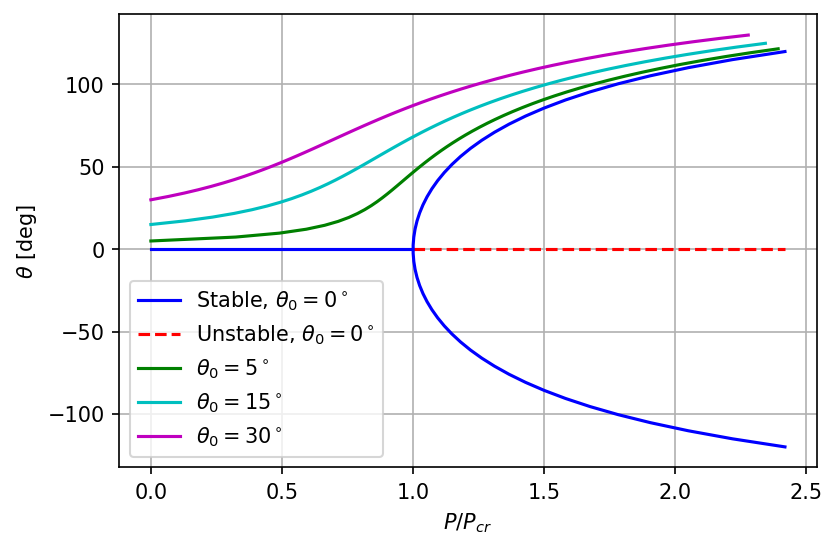

In [3]:
import matplotlib.pyplot as plt  # plotting package
import numpy as np  # package for matrix operations
plt.rcParams['figure.dpi'] = 150  # set default dpi of figures
fig, ax = plt.subplots()  # create figure
# Plot equilibrium diagram of perfect system
theta_trivial_stable = np.array([0., 0.])  # deg
load_trivial_stable = np.array([0., 1.])
theta_nontrivial = np.linspace(-120, 120)  # deg
load_nontrivial = np.deg2rad(theta_nontrivial)/np.sin(np.deg2rad(theta_nontrivial))
theta_trivial_unstable = np.array([0., 0.])  # deg
load_trivial_unstable = np.array([1., np.max(load_nontrivial)])
stability_styles = {'stable': '-b', 'unstable': '--r'}  # legend styles
ax.plot(load_trivial_stable, theta_trivial_stable, stability_styles['stable'], label='Stable, $\\theta_0 = 0^\circ$')  # plot trivial stable solution
ax.plot(load_trivial_unstable, theta_trivial_unstable, stability_styles['unstable'], label='Unstable, $\\theta_0 = 0^\circ$')  # plot trivial unstable solution
ax.plot(load_nontrivial, theta_nontrivial, stability_styles['stable'])  # plot nontrivial solution
# Plot equilibrium diagram of imperfect system
imperfections = [5, 15, 30]  # theta_0 [deg]
theta_0_styles = {5: '-g', 15: '-c', 30: '-m'}  # legend styles
for theta_0 in imperfections:  # iterate through initial angles theta_0
    theta_imperfection = np.linspace(theta_0, 120 + theta_0/3)
    load_imperfection = (np.deg2rad(theta_imperfection-theta_0))/np.sin(np.deg2rad(theta_imperfection))
    ax.plot(load_imperfection, theta_imperfection, theta_0_styles[theta_0], label='$\\theta_0={:d}^\circ$'.format(theta_0))
# Set plot appearance
ax.set_xlabel('$P/P_{cr}$')
ax.set_ylabel('$\\theta$ [deg]')
ax.legend()
ax.grid()
plt.show()

## Setup of the numerical model <a name="numerical-model"></a>

***

We consider the same column of our [last notebook](01_Buckling_Analysis_Euler_Column.ipynb) and we create our `BDF` object calling the `create_base_bdf` function from the `column_utils` module.

In [4]:
from resources import column_utils
E = 207000.  # [MPa]
nu = 0.3
rho = 7.8e-4  # [tons/mm^3]
d = 20  # [mm]
l = 420  # [mm]
no_elements = 420
bdf_input = column_utils.create_base_bdf(young_modulus=E, poisson_ratio=nu, density=rho, diameter=d, length=l, no_elements=no_elements)

subcase=0 already exists...skipping


Let's visualize some statistics about our `BDF` object.

In [5]:
print(bdf_input.get_bdf_stats())

---BDF Statistics---
SOL None

bdf.loads[4]
  FORCE:   1

bdf.spcadds[3]
  SPCADD:  1

bdf.spcs[1]
  SPC1:    1

bdf.spcs[2]
  SPC1:    1

bdf.params
  PARAM    : 1

bdf.nodes
  GRID     : 421

bdf.elements
  CBEAM    : 420

bdf.properties
  PBEAML   : 1

bdf.materials
  MAT1     : 1




Before moving on to the definition of the load case sequence, we recall the buckling load calculated by SOL 105 in our last notebook, which we will use to nondimensionalize the results.

In [6]:
sol105_buckling_load = 90578.  # [N]

## Load case sequence definition <a name="subcases-definition"></a>

***

In order to reproduce the supercritical pitchfork bifurcation with our numerical model, we need to obtain the stable branch up to the buckling load, the unstable branch beyond the buckling load and one of the two symmetrical stable branches beyond the buckling load. In addition, we also want to visualize the broken pitchfork, in order to notice the influence of an initial imperfection or of an eccentricity in the load.

Our approach to obtain the above is to define a load case sequence that will allow us to move along the different branches of Euler's column equilibrium diagram. We use Nastran's subcases to obtain such load case sequence, and we define our subcases in the following way.

1. Apply a compression load larger than the buckling load at the roller-supported end of the column. We expect to follow the straight stable branch of the pitchfork and as the load increases we expect to move on to the unstable branch.

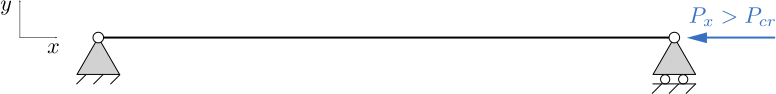

In [7]:
SVG(filename=os.path.join('resources', '02_Subcase1.svg'))

2. Add a small transverse load at the middle of the column. This will break the symmetry of the problem and consequently also the supercritical pitchfork bifurcation. We expect the equilibrium point to move onto the branch corresponding to the broken pitchfork, with a certain deflection of the column in the same direction of the applied transverse load.

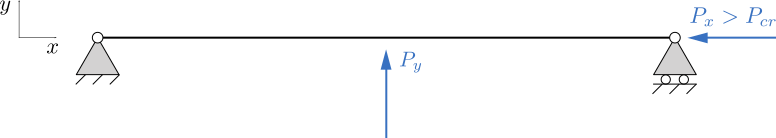

In [8]:
SVG(filename=os.path.join('resources', '02_Subcase2.svg'))

3. Remove the transverse load in order to restore the symmetry of the problem. At this point also the supercritical pitchfork bifurcation will be restored and we expect the equilibrium point to move onto the stable branch of the unbroken pitchfork corresponding to the direction of the tranverse load that was just removed. We expect to still observe a non-zero deflection of the column.

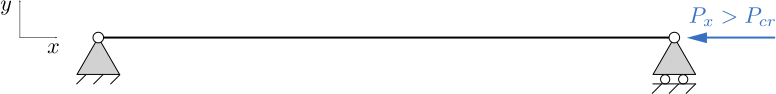

In [9]:
SVG(filename=os.path.join('resources', '02_Subcase1.svg'))

4. Remove the compression load. We expect this to move the equilibrium point along the curved stable branch of the unbroken pitchfork until we get back to the straight stable branch and we sweep it back to the undeformed state of the column.

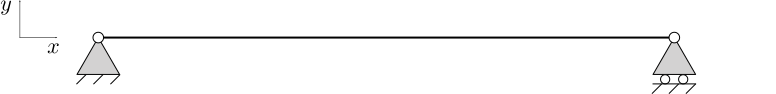

In [10]:
SVG(filename=os.path.join('resources', '02_Subcase4.svg'))

5. Apply both the compression and the transverse load at the same time. This will let us visualize the equilibrium path of the broken pitchfork.

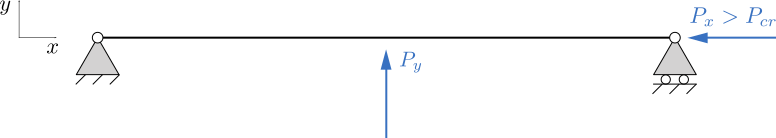

In [11]:
SVG(filename=os.path.join('resources', '02_Subcase2.svg'))

Let's start by defining the compression force and the transverse force, which we will later assign to the different load sets. We consider a compression force equal to twice the buckling load calculated with SOL 105, $P_x/P_{cr}=2$, while we set the transverse force as a fraction of the buckling load, $P_y/P_{cr}=1/100$. The FORCE card corresponding to the compression force has already been created by the `create_base_bdf` function, so we only need to change its magnitude, while we need to create a new FORCE card corresponding to the transverse force.

In [12]:
# Change magnitude of compression force
compression_force_set_id = list(bdf_input.loads.keys())[0]
bdf_input.loads[compression_force_set_id][0].mag = sol105_buckling_load*2
# Define transverse force
transverse_force_set_id = compression_force_set_id+1
middle_node_id = int(no_elements/2+1)
transverse_force_magnitude = sol105_buckling_load/100
transverse_force_direction = [0., 1., 0.]
bdf_input.add_force(sid=transverse_force_set_id, node=middle_node_id, mag=transverse_force_magnitude, xyz=transverse_force_direction)

FORCE          5     211          905.78      0.      1.      0.

Now we define the two load combinations that we need to create our subcases: one with compression and transverse force and one with no applied force.

In [13]:
# Define load set with combined forces
combined_load_set_id = transverse_force_set_id+1
bdf_input.add_load(combined_load_set_id, scale=1., scale_factors=[1., 1.], load_ids=[compression_force_set_id, transverse_force_set_id])
# Define load set with no applied force
zero_load_set_id = combined_load_set_id+1
bdf_input.add_load(zero_load_set_id, scale=1., scale_factors=[0.], load_ids=[compression_force_set_id])

LOAD           7      1.      0.       4

We finally define our subcases as explained earlier using the `create_static_load_subcase` function from the `pynastran_utils` module.

In [14]:
from resources import pynastran_utils
pynastran_utils.create_static_load_subcase(bdf_object=bdf_input, subcase_id=1, load_set_id=compression_force_set_id)  # first subcase
pynastran_utils.create_static_load_subcase(bdf_object=bdf_input, subcase_id=2, load_set_id=combined_load_set_id)  # second subcase
pynastran_utils.create_static_load_subcase(bdf_object=bdf_input, subcase_id=3, load_set_id=compression_force_set_id)  # third subcase
pynastran_utils.create_static_load_subcase(bdf_object=bdf_input, subcase_id=4, load_set_id=zero_load_set_id)  # fourth subcase
pynastran_utils.create_static_load_subcase(bdf_object=bdf_input, subcase_id=5, load_set_id=combined_load_set_id)  # fifth subcase

## Full Newton method <a name="newton"></a>

***

The first nonlinear iteration strategy that we want to test is the full Newton method. Consequently, we choose SOL 106 as solution sequence and we define a NLPARM card with the following parameters:
* `ninc=100` to set the number of load increments;
* `kmethod='ITER'` and `kstep=1` to update the stiffness matrix at every iteration;
* `max_iter=25` to set the maximum number of iterations for each load increment;
* `conv='PUV'` to select convergence criteria based on load equilibrium error with vector component method;
* `int_out='YES'` to process the output for every computed load increment;
* `eps_p=1e-3` and `eps_u=1e-3` to set the error tolerance for the load and displacement criteria, respectively;
* `max_bisect=10` to set the maximum number of bisections allowed for each load increment.

We assign the id of the NLPARM card as default for all subcases.

In [15]:
bdf_input.sol = 106
nlparm_id = 1
bdf_input.add_nlparm(nlparm_id=nlparm_id, ninc=100, kmethod='ITER', kstep=1, max_iter=25, conv='PV', int_out='YES', eps_p=1e-3, eps_u=1e-3, max_bisect=10)
bdf_input.case_control_deck.subcases[0].add_integer_type('NLPARM', nlparm_id)

We also need to define the additional parameter `PARAM,LGDISP,1` to assume all nonlinear structural element types with large displacement capability to have large displacement effects.

In [16]:
bdf_input.add_param('LGDISP', [1])

PARAM     LGDISP       1

We can now run the analysis with Nastran.

In [17]:
# Define name of analysis directory
analysis_directory_name = '02_Supercritical_Pitchfork_Bifurcation_Euler_Column'
analysis_directory_path = os.path.join(os.getcwd(), 'analyses', analysis_directory_name)
# Define input name
input_name = 'full_newton_method'
# Run analysis
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=bdf_input, bdf_filename=input_name)

Once the analysis is done, we can read the op2 file and find the load-displacement history for all subcases using the `read_load_displacement_history_from_op2` function from the `pynastran_utils` module. This function returns the history of the load step, overall applied load, displacements and rotations at the requested node for each subcase of the analysis. We read the displacements and rotations at the hinge-supported node (node id equal to 1) because we want to assess the equilibrium diagram of the column in terms of the rotation $\theta$ at that node.

In [18]:
from pyNastran.op2.op2 import read_op2  # function to read op2 file
# Read op2 file
op2_filepath = os.path.join(analysis_directory_path, input_name + '.op2')
op2_output = read_op2(op2_filename=op2_filepath, debug=False)
# Read load displacement history
load_steps, applied_loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=1)

We want to plot the results of our analysis in terms of equilibrium paths. For each converged iteration of each subcase we want to visualize:
 * load step versus $\theta$;
 * applied load along $x$ versus $\theta$;
 * applied load along $y$ versus $\theta$.

In addition we also want to print the value of $\theta$ at the end of each subcase. We define the `plot_2d_equilibrium_paths` function to do all of the above and we call it to show the results of our analysis.

Subcase 1: theta = 0.00 degrees
Subcase 2: theta = 124.04 degrees
Subcase 3: theta = 124.08 degrees
Subcase 4: theta = 0.00 degrees
Subcase 5: theta = 124.04 degrees


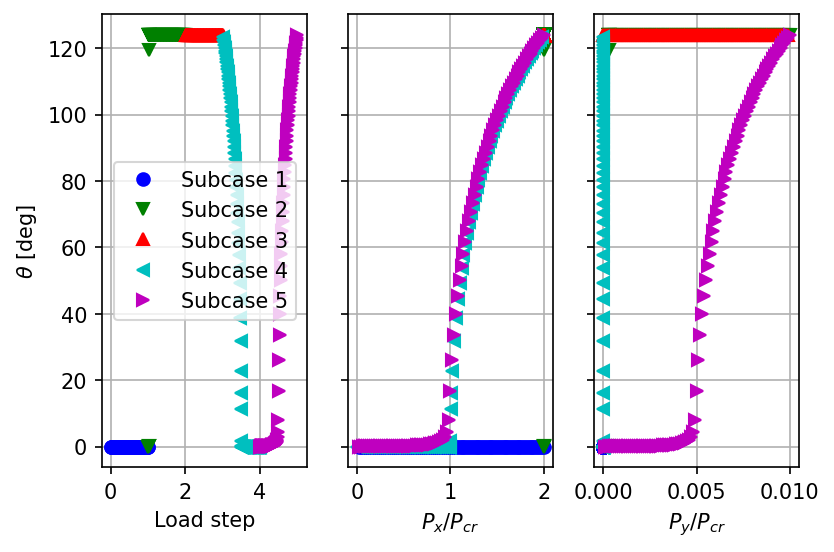

In [19]:
def plot_2d_equilibrium_paths(disp, steps, loads):
    # Set plotting style for different subcases
    subcase_styles = {1: 'ob', 2: 'vg', 3: '^r', 4: '<c', 5: '>m', 6: '1y', 7: '2k'}
    # Create figure with subplots
    _, axs = plt.subplots(nrows=1, ncols=3, sharey='all')
    # Iterate over the subcases
    for subcase_id in disp:
        # Convert rotation angle from radians to degrees
        theta = np.rad2deg(disp[subcase_id][:,5])
        # Print rotation at the end of subcase
        print(f'Subcase {subcase_id:d}: theta = {theta[-1]:.2f} degrees')
        # Plot load step vs rotation
        axs[0].plot(steps[subcase_id], theta, subcase_styles[subcase_id], label='Subcase {:d}'.format(subcase_id))
        # Plot applied load along x vs rotation
        axs[1].plot(-loads[subcase_id][:,0]/sol105_buckling_load, theta, subcase_styles[subcase_id], label='Subcase {:d}'.format(subcase_id))  # sign of load along x is inverted to show a positive load in the plot
        # Plot applied load along y vs rotation
        axs[2].plot(loads[subcase_id][:,1]/sol105_buckling_load, theta, subcase_styles[subcase_id], label='Subcase {:d}'.format(subcase_id))
    # Set plot appearance
    axs[0].set_xlabel('Load step')
    axs[0].set_ylabel('$\\theta$ [deg]')
    axs[0].grid(visible=True)
    axs[1].set_xlabel('$P_x/P_{cr}$')
    axs[1].grid(visible=True)
    axs[2].set_xlabel('$P_y/P_{cr}$')
    axs[2].grid(visible=True)
    axs[0].legend()
    # Show plot
    plt.show()

plot_2d_equilibrium_paths(displacements, load_steps, applied_loads)

We can make the following observations.
* During the first subcase the rotation $\theta$ is always null. The equilibrium point moves along the straight stable branch of the equilibrium diagram ($P_x/P_{cr}<1$) and then along the unstable branch ($P_x/P_{cr}>1$).
* In subcase 2, $\theta$ jumps from zero to about 124 degrees, with the equilibrium point moving from the unstable branch of the unbroken pitchfork to the broken pitchfork.
* During the third subcase the equilibrium point moves from the broken pitchfork to the curved stable branch of the unbroken pitchfork. Unexpectedly, at the end of the subcase $\theta$ is slightly smaller with respect to the value at the end of subcase 2. This is in contrast with the results of the 1 DOF system, where the imperfect sytem always shows a larger value of $\theta$ for the same applied load $P_x/P_{cr}$ with respect to the perfect system.
* In subcase 4, the equilibrium point moves along the curved stable branch of the unbroken pitchfork as the column is unloaded and for $P_x/P_{cr}<1$ it traverses the straight stable branch until the structures goes back to its undeformed state (null rotation).
* In subcase 5 we can observe the equilibrium path corresponding to the broken pitchfork. In particular, it is evident how the path of the broken pitchfork deviates from the one of the unbroken pitchfork, especially close to $P_x/P_{cr}=1$. The final value of $\theta$ corresponds to the one obtained for the second subcase.

Apart from the value of $\theta$ at the end of the third subcase, all the observations are in line with our expectations.

We can also visualize the equilibrium paths with a 3D plot, showing $\theta$, $P_x/P_{cr}$ and $P_y/P_{cr}$ at the same time. We define the `plot_3d_equilibrium_paths` function for such purpose and we call it to plot our results in 3D.

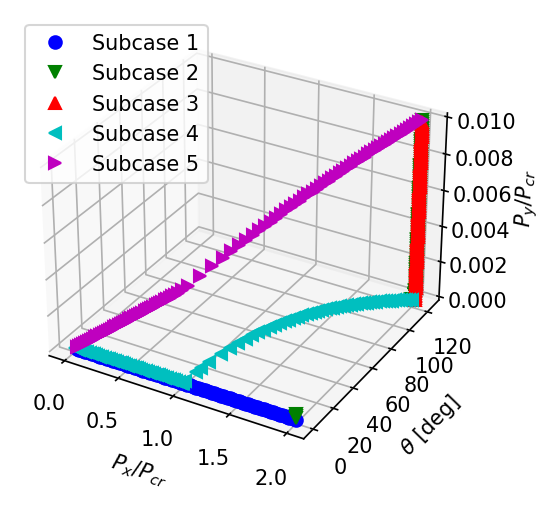

In [20]:
from mpl_toolkits import mplot3d
def plot_3d_equilibrium_paths(disp, loads):
    # Set plotting style for different subcases
    style = {1: 'ob', 2: 'vg', 3: '^r', 4: '<c', 5: '>m', 6: '1y', 7: '2k'}
    # Create figure with three-dimensional axes
    plt.figure()
    ax = plt.axes(projection='3d')
    # Plot load applied along x vs rotation of pin-supported node vs applied along y
    for subcase_id in disp:
        ax.plot3D(-loads[subcase_id][:,0]/sol105_buckling_load, np.rad2deg(disp[subcase_id][:,5]), loads[subcase_id][:,1]/sol105_buckling_load, style[subcase_id], label='Subcase {:d}'.format(subcase_id))  # sign of load along x is inverted to show a positive load in the plot
    ax.set_xlabel('$P_x/P_{cr}$')
    ax.set_ylabel('$\\theta$ [deg]')
    ax.set_zlabel('$P_y/P_{cr}$')
    ax.legend()
    ax.grid(visible=True)
    plt.show()

plot_3d_equilibrium_paths(displacements, applied_loads)

Here we can recognize equilibrium path of the classical supercritical pitchfork bifurcation on the $P_x/P_{cr}-\theta$ plane and the jump of $\theta$ during subcase 2. We remind that the employed Newton method is based on load control, so the jump in subcase 2 suggests the presence of a limit point, which we should be able to observe calculating the equilibrium path with the arc-length method. Finally, the 3D view enables the observation of two features.
* The path of the broken pitchfork is actually three-dimensional when we also consider the transverse load as an independent parameter of the system.
* The unbroken and the broken pitchforks are connected by the equilibrium path found in subcase 3.

## Arc-length method <a name="arc-length"></a>
Now we want to analyze the supercritical pitchfork bifurcation using the arc-length incremental solution strategy. In this way we will be able to follow the equilibrium paths of the column also beyond limit points.

To use the arc-length method in SOL 106, we need to add a `NLPCI` card with the following parameters:
* `Type='CRIS'` to set Crisfield constraint type;
* `minalr=.01` and `maxalr=1.1` to set the minimum and maximum allowable arc-length adjustment ratio between increments, $MINALR \leq\frac{\Delta l_{new}}{\Delta l_{old}}\leq MAXALR$. Smaller values of $MAXALR$ were tested, but the analysis appeared to get stuck during subcase 4 around the bifurcation point;
* `desiter=5` to set the desired number of iterations for convergence, which is used for the arc-length adjustment: $\Delta l_{new}=\Delta l_{old}\sqrt{DESITER/I_{max}}$ (where $I_{max}$ represents the number of iterations required for convergence in the previous load increment);
* `mxinc=2000` to set the maximum number of controlled increment steps allowed within a subcase.

In [21]:
bdf_input.add_nlpci(nlparm_id, Type='CRIS', minalr=.01, maxalr=1.1, desiter=5, mxinc=2000)

NLPCI          1    CRIS     .01     1.1      0.               5    2000

Let's run the analysis.

In [22]:
# Define input name
input_name = 'arclength_method'
# Run analysis
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=bdf_input, bdf_filename=input_name)

We plot the results of our analysis in an analogous way as done for the full Newton method.

Subcase 1: theta = 0.00 degrees
Subcase 2: theta = -0.38 degrees
Subcase 3: theta = 0.00 degrees
Subcase 4: theta = -0.00 degrees
Subcase 5: theta = 124.04 degrees


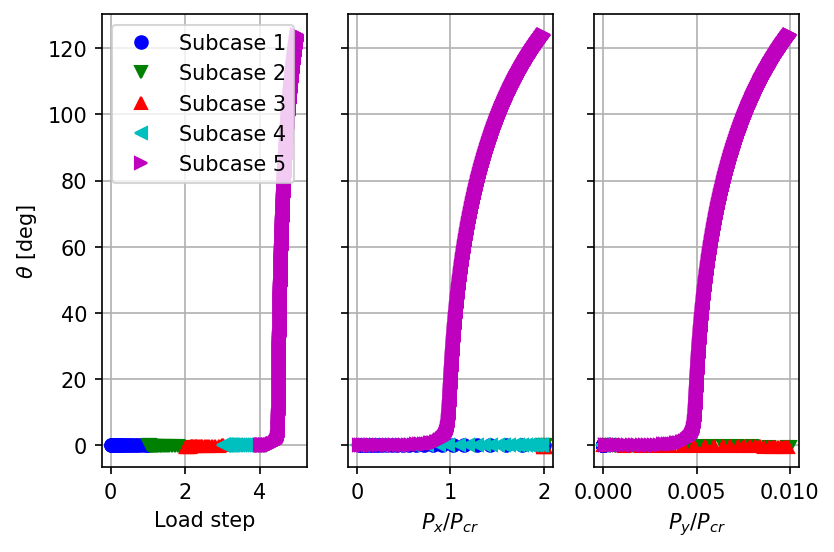

In [23]:
# Read op2 file
op2_filepath = os.path.join(analysis_directory_path, input_name + '.op2')
op2_output = read_op2(op2_filename=op2_filepath, debug=False)
# Read load displacement history
load_steps, applied_loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=1)
# Plot equilibrium paths
plot_2d_equilibrium_paths(displacements, load_steps, applied_loads)

We can easily observe some differences with respect to the full Newton method analysis.
* Only the equilibrium path of the broken pitchfork is obtained, while the unbroken pitchfork is not captured. More in particular, the analysis can successfully traverse the straight stable and unstable branches of the unbroken pitchfork, but it fails to switch from the straihgt unstable branch of the unbroken pitchfork to the broken pitchfork during subcase 2.
* The value of $\theta$ at the end of the second subcase is slightly negative. This appears to be counterintuitive, as it means that the column is deflecting towards the opposite direction with respect to the one of the applied transverse load.

Also in this case we plot the 3D equilibrium paths to have another visualization of our results.

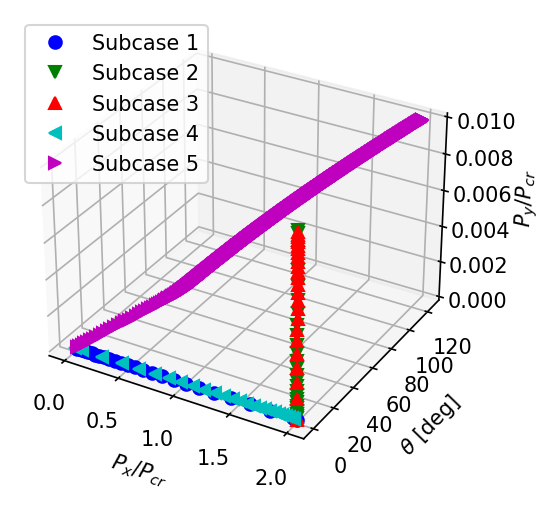

In [24]:
plot_3d_equilibrium_paths(displacements, applied_loads)

Considering the jump that we observed with the Newton method in subcase 2, we would expect to observe a limit point with the arc-length method. However, we cannot see any evidence of such limit point, rather the structure follows an equilibrium path with slightly negative values of $\theta$. As a consequence, we need to investigate the equilibrium path around $P_x/P_{cr}=2$ more in detail.

### Investigation of equilibrium paths around $P_x/P_{cr}=2$ <a name="pxpcr2-investigation"></a>

We investigate the behavior of the equilibrium path around $P_x/P_{cr}=2$ applying a large transverse force first in one direction and then in the opposite one. For this purpose we need to make a deep copy of our `BDF` object and to modify the subcases in the following way:
1. Subcase 1 stays unchanged.
2. In subcase 2 we keep the compression force and apply a large transverse force, setting $P_y/P_{cr}=100$, in order to examine in detail the equilibrium path.
3. In subcase 3 we keep the compression force, remove the transverse force and apply another transverse force with $P_y/P_{cr}=-100$, so equal but in opposite direction with respect to the force applied in subcase 2. In this way we study the other side of the equilibrium path.
4. Subcases 4 and 5 are removed.

We use the same NLPARM and NLPCI cards used previously. Smaller values of MAXALR were also tested, but no significant change in the results was observed.

In [25]:
pxpcr2_investigation_input = bdf_input.__deepcopy__({})  # deep copy of original BDF object
# Remove subcases 4 and 5
del pxpcr2_investigation_input.subcases[4]
del pxpcr2_investigation_input.subcases[5]
# Modify magnitude of transverse force in subcase 2
pxpcr2_investigation_input.loads[transverse_force_set_id][0].mag = sol105_buckling_load*100
# Add new load combination with transverse load in opposite direction
combined_load_opposite_direction_set_id = zero_load_set_id+1
scale_factors = [1., -1.]
pxpcr2_investigation_input.add_load(combined_load_opposite_direction_set_id, 1., scale_factors, [compression_force_set_id, transverse_force_set_id])
# Modify subcase 3
pxpcr2_investigation_input.subcases[3].params['LOAD'][0] = combined_load_opposite_direction_set_id

Let's run the analysis and visualize the results.

Subcase 1: theta = 0.00 degrees
Subcase 2: theta = -256.42 degrees
Subcase 3: theta = 256.43 degrees


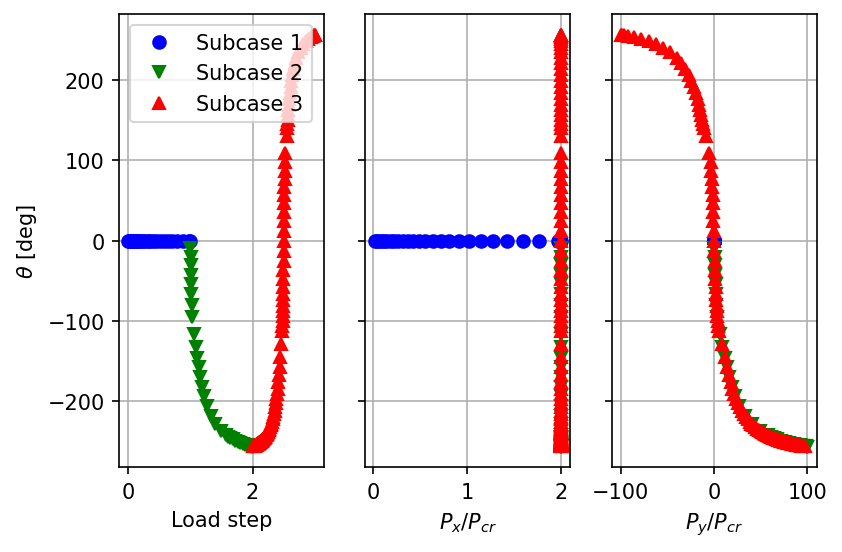

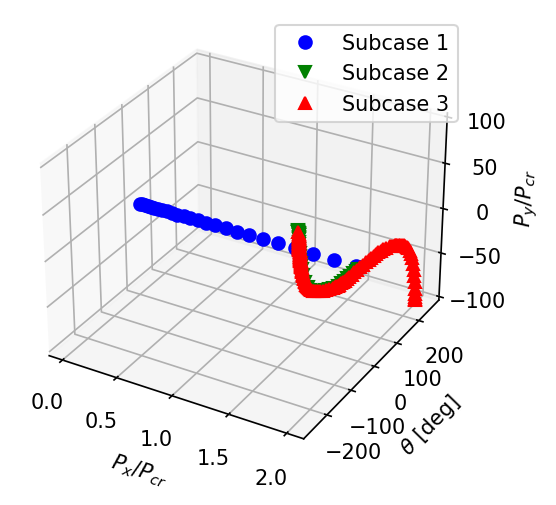

In [26]:
# Define input name
input_name = 'arclength_method_PxPcr2_investigation'
# Run analysis
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=pxpcr2_investigation_input, bdf_filename=input_name)
# Read op2 file
op2_filepath = os.path.join(analysis_directory_path, input_name + '.op2')
op2_output = read_op2(op2_filename=op2_filepath, debug=False)
# Read load displacement history
load_steps, applied_loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=1)
# Plot equilibrium paths
plot_2d_equilibrium_paths(displacements, load_steps, applied_loads)
plot_3d_equilibrium_paths(displacements, applied_loads)

From the results it appears that the equilibrium path on the $P_x/P_{cr}=2$ plane predicts a downward deflection of the column for an upward transverse force and vice versa. Once again, we cannot observe the presence of a limit point and the equilibrium path does not seem to justify the jump that we observed with the Newton method.

Let's try a different sequence of subcases to investigate the equilibrium paths on the $P_x/P_{cr}=2$ plane. We create a deep copy of our orifinal `BDF` object and we define the following subcases.
1. Apply combined compression and transverse force, with $P_x/P_{cr}=2$ and $P_y/P_{cr}=1/100$. In this way the equilibrium point moves along the path of the broken pitchfork.
2. Keep the compression load and reverse the transverse load, setting $P_y/P_{cr}=-100$. The idea here is to observe whether we are able to switch from one side of the broken pitchfork to the other side. We set a larger magnitude for the transverse load to overcome potential limit points in the equilibrium path.

In [27]:
alternative_subcases_input = bdf_input.__deepcopy__({})  # deep copy of origial BDF object
# Modify subcase 1
alternative_subcases_input.subcases[1].params['LOAD'][0] = combined_load_set_id
# Add load combination with transverse load in opposite direction
scale_factors = [1., -10000.]
alternative_subcases_input.add_load(combined_load_opposite_direction_set_id, 1., scale_factors, [compression_force_set_id, transverse_force_set_id])
# Modify subcase 2
alternative_subcases_input.subcases[2].params['LOAD'][0] = combined_load_opposite_direction_set_id
# Remove subcases 3 to 5
del alternative_subcases_input.subcases[3]
del alternative_subcases_input.subcases[4]
del alternative_subcases_input.subcases[5]

Once again, let's run the analysis and visualize the results.

Subcase 1: theta = 124.04 degrees
Subcase 2: theta = 90.02 degrees


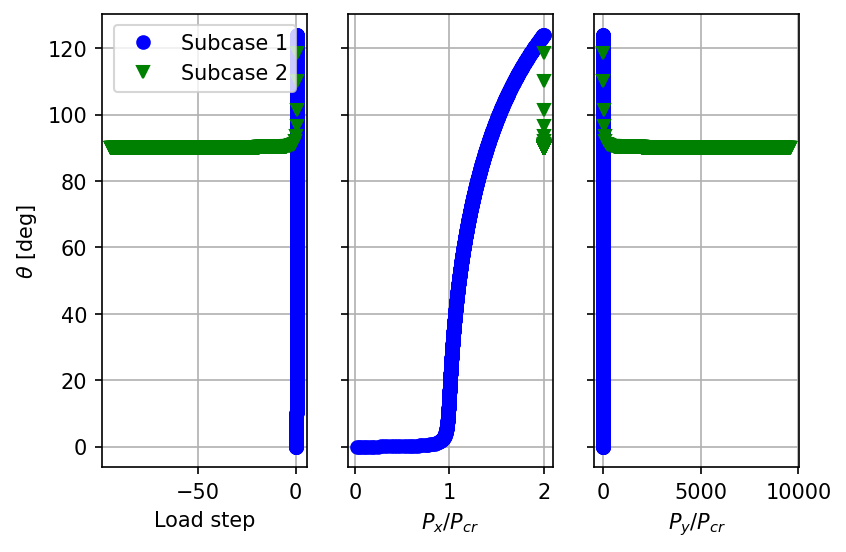

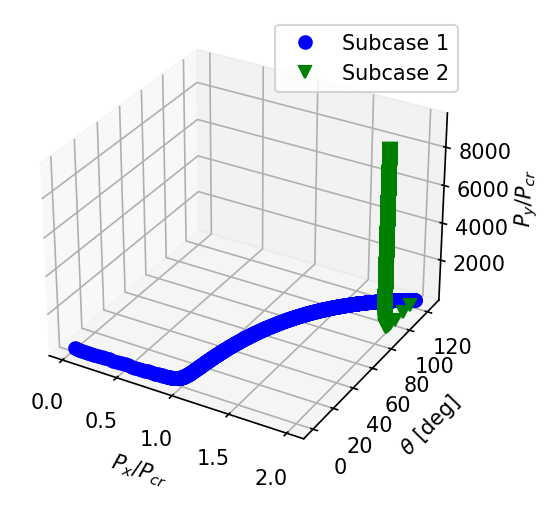

In [28]:
# Define input name
input_name = 'arclength_method_PxPcr2_investigation_alternative_subcases'
# Run analysis
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=alternative_subcases_input, bdf_filename=input_name)
# Read op2 file
op2_filepath = os.path.join(analysis_directory_path, input_name + '.op2')
op2_output = read_op2(op2_filename=op2_filepath, debug=False)
# Read load displacement history
load_steps, applied_loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=1)
# Plot equilibrium paths
plot_2d_equilibrium_paths(displacements, load_steps, applied_loads)
plot_3d_equilibrium_paths(displacements, applied_loads)

The nonlinear analysis does not converge to the desired load in subcase 2. We can observe negative load steps, indicating that the arc-length tries to seek a root in the loading direction of the previous subcase. As a consequence, the arc-length solver applies an increasing upward force instead of applying the defined downward force. The analysis stops because the maximum number of increments is reached.

Since the arc-length method seems to encounter issues when the sign of the transverse force is inverted, we try to repeat the analysis substituting the arc-length method with the full Newton method in subcase 2. For this purpose we need to add another `NLPARM` card to the model and assign its id to subcase 2.

In [29]:
# Define NLPARM card for Newton method
nlparm2_id = 2
alternative_subcases_input.add_nlparm(nlparm2_id, ninc=100, kmethod='ITER', kstep=1, max_iter=25, conv='PV', int_out='YES', eps_p=1e-3, max_bisect=10)
# Set NLPARM id of second subcase
alternative_subcases_input.case_control_deck.subcases[2].add_integer_type('NLPARM', nlparm2_id)

Then we run the analysis and plot the results.

Subcase 1: theta = 124.04 degrees
Subcase 2: theta = 267.67 degrees


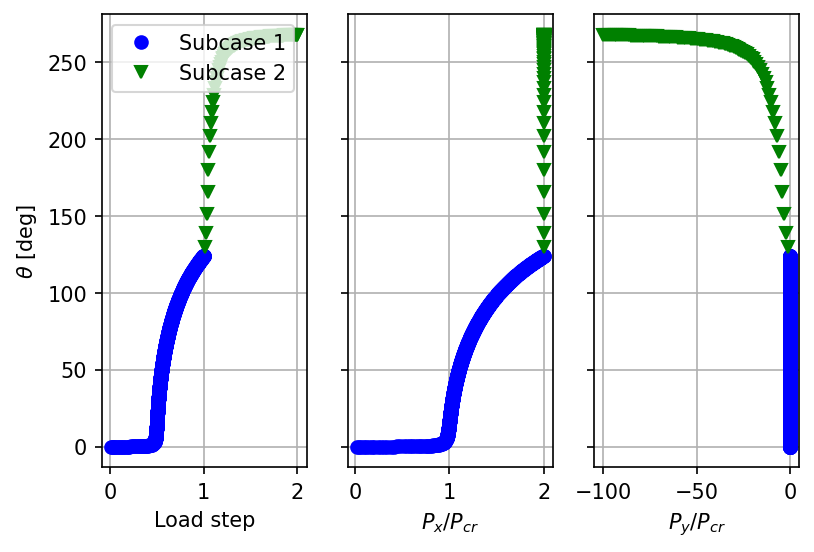

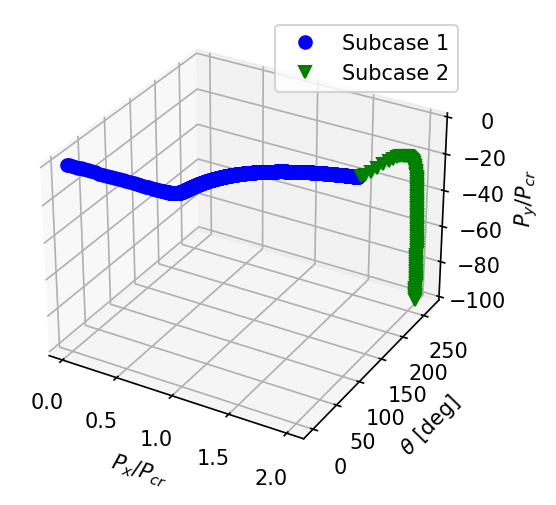

In [30]:
# Define input name
input_name = 'mixed_methods_PxPcr2_investigation_alternative_subcases'
# Run analysis
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=alternative_subcases_input, bdf_filename=input_name)
# Read op2 file
op2_filepath = os.path.join(analysis_directory_path, input_name + '.op2')
op2_output = read_op2(op2_filename=op2_filepath, debug=False)
# Read load displacement history
load_steps, applied_loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=1)
# Plot equilibrium paths
plot_2d_equilibrium_paths(displacements, load_steps, applied_loads)
plot_3d_equilibrium_paths(displacements, applied_loads)

We observe that with the Newton method we are able to traverse the equilibrium path for negative values of $P_y/P_{cr}$. However, we notice that for the investigated range of transverse loads, the equilibrium path does not seem to point towards the other side of the broken pitchfork.

### Reduced compression force <a name="reduced-compression"></a>

At this point we want to assess how the equilibrium paths change across different $P_x/P_{cr}=c$ planes, with $c$ constant. We use the same load case sequence defined within the `alternative_subcase_input` object, with the following values of $P_x/P_{cr}$: 1.1, 1.4, 1.7. For each value of $P_x/P_{cr}$ we adjust the value of $P_y/P_{cr}$ in the second subcase. The reason for this will be evident when looking at the results.

We proceed with modifying the subcases, running the analysis and plotting the results for each value of $P_x/P_{cr}$.

Px/Pcr=1.1


Subcase 1: theta = 50.66 degrees
Subcase 2: theta = -58.81 degrees


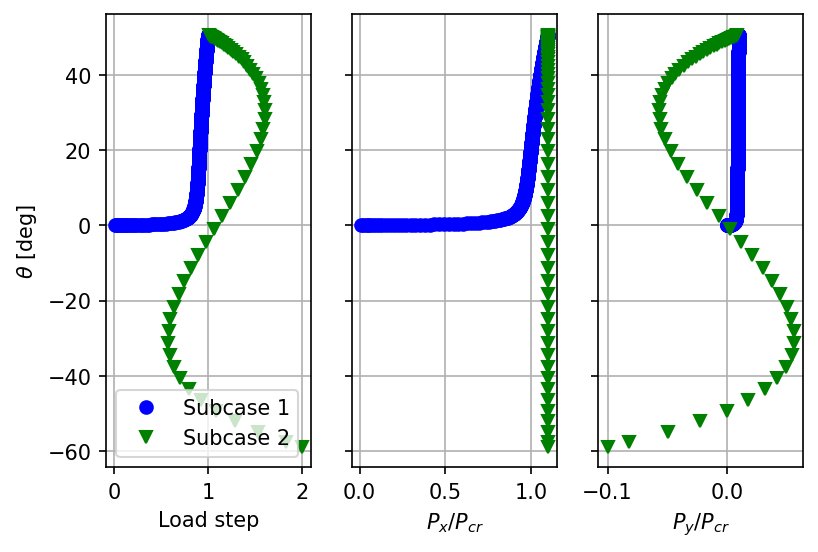

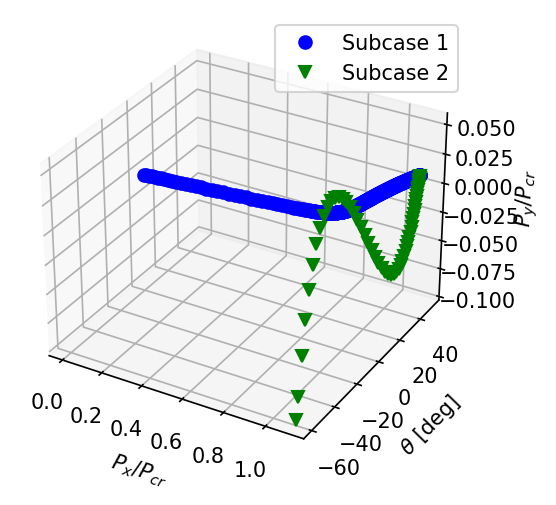

Px/Pcr=1.4


Subcase 1: theta = 90.37 degrees
Subcase 2: theta = -97.01 degrees


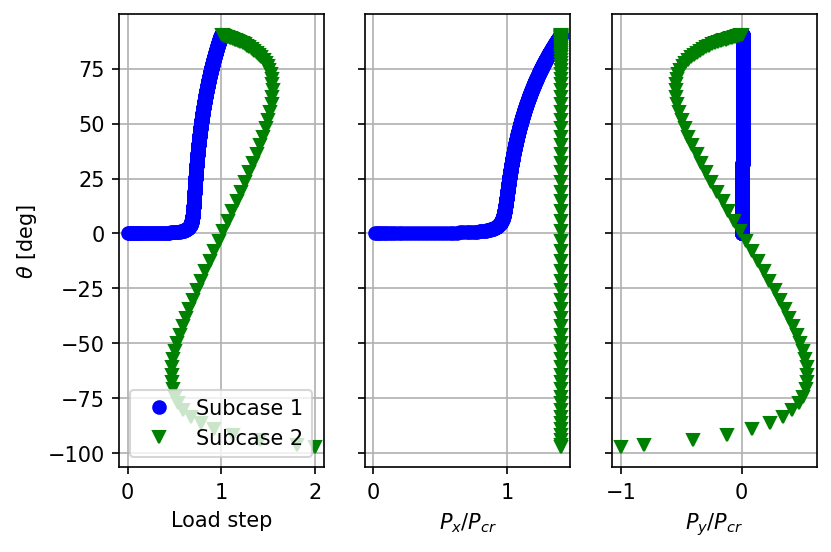

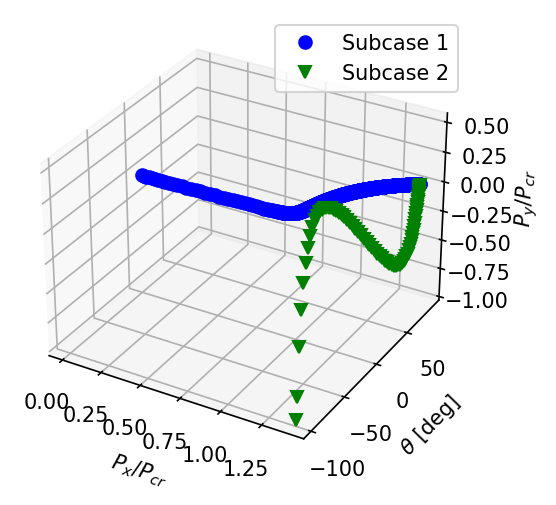

Px/Pcr=1.7


Subcase 1: theta = 110.76 degrees
Subcase 2: theta = -105.68 degrees


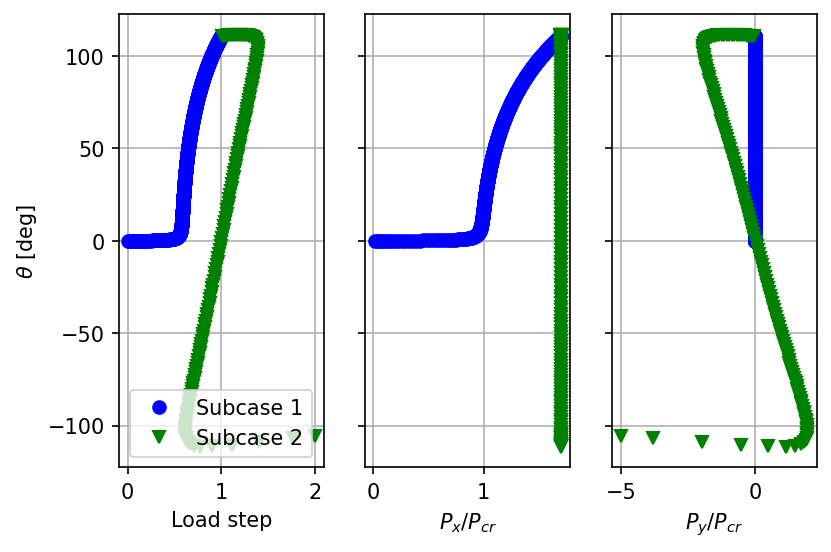

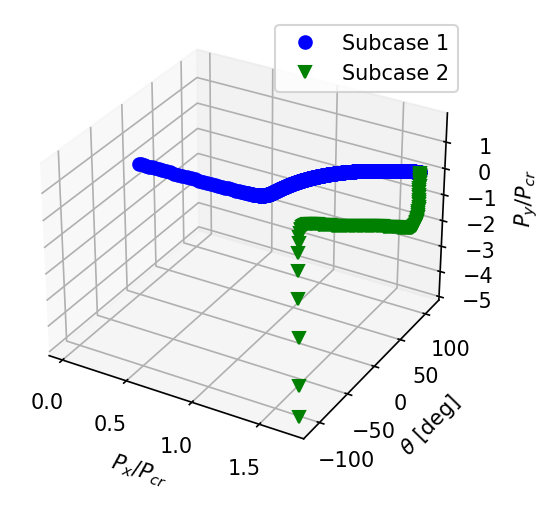

In [31]:
# Set the NLPARM id of subcase 2 to the id of the NLPARM card defining the arc-length method
alternative_subcases_input.subcases[2].params['NLPARM'][0] = nlparm_id
# Define values of Px/Pcr
compression_force_factors = [1.1, 1.4, 1.7]
# Define values of Py/Pcr
transverse_load_factors = [-1e1, -1e2, -5e2]
# Iterate through the different values of Px/Pcr and Py/Pcr
for force_factor, scale_factor in zip(compression_force_factors, transverse_load_factors):
    # Print value of compression force
    print('\033[1m' + f'Px/Pcr={force_factor:.1f}' + '\033[0m')
    # Modify magnitude of compression force
    alternative_subcases_input.loads[compression_force_set_id][0].mag = sol105_buckling_load*force_factor
    # Modify scale factor of transverse load in subcase 2
    alternative_subcases_input.load_combinations[combined_load_opposite_direction_set_id][0].scale_factors[1] = scale_factor
    # Define input name
    reduced_compression_force_input_name = f'arclength_method_PxPcr_{force_factor:.1f}'.replace('.','_')
    # Run analysis
    pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=alternative_subcases_input, bdf_filename=input_name)
    # Read op2 file
    op2_filepath = os.path.join(analysis_directory_path, input_name + '.op2')
    op2_output = read_op2(op2_filename=op2_filepath, debug=False)
    # Read load displacement history
    load_steps, applied_loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=1)
    # Plot equilibrium paths
    plot_2d_equilibrium_paths(displacements, load_steps, applied_loads)
    plot_3d_equilibrium_paths(displacements, applied_loads)

The results of these analyses show the presence of a snap-through behavior when moving from one side to the other of the broken pitchfork. Subcase 1 brings the structure onto a point of the broken pitchfork corresponding to an upward deflection of the column (positive $\theta$). In subcase 2 the positive transverse force is gradually unloaded and the negative transverse force is loaded on the structure. As a consequence, during this process the transverse force becomes null and then negative with increasing magnitude, until a limit point is encountered. After this point the transverse force decreases in magnitude until it becomes null and changes sign. Once again, the force increases in magnitude until it encounters another limit point, this time for a positive force. Subsequently, the force decreases in magnitude, becomes null, changes its sign back to negative and finally achieves the prescribed value.

It should be noted that $P_y$ becomes null three times along the equilibrium path. Once for a positive value of $\theta$, once for $\theta=0$ and once for a negative value of $\theta$. This means that when moving from one side of the broken pitchfork to the other, the equilibrium path crosses the branches of the unbroken pitchfork, where $P_y$ is null.

Furthermore, we can observe that the curve describing the equilibrium path connecting the two sides of the pitchfork changes with the compression load $P_x$. Not only the location of the limit points is different, but the overall shape of the curve changes. For example, we can notice how the slope at the start of subcase 2 is different and if for $P_x/P_{cr}=1.1$ and $1.4$ the angle $\theta$ decreases, for $P_x/P_{cr}=1.7$ $\theta$ has a slight increase before becoming smaller along the curve. This means that the level of compression of the column influences the equilibrium path connecting the two sides of the pitchfork. As a consequence, it is possible that for $P_x/P_{cr}=2$ the equilibrium path becomes more complex and that we are not able to traverse it within the prescribed maximum number of iterations.

Finally, looking at the equilibrium point where $P_y=0$ and $\theta=0$, we notice the same seemingly nonphysical behavior that we observed in a previous analysis, that is to say downward deflection (negative $\theta$) for upward force (positive $P_y$) and vice versa. This can be explained by the fact that the points on that equilibrium path are all unstable, so when the column has a slight upward deflection, a downward force is needed to keep it in equilibrium and to prevent it from snapping to the stable branch of the pitchfork. Analogously, when the column has a slight downward deflection, an equilibrium configuration can only be obtained with the application of an upward force that prevents the column from snapping further downward.

## Final supercritical pitchfork bifurcation analysis <a name="final"></a>

***

We conclude this series of analyses with an investigation on both sides of the pitchfork. We define the following subcases.

1. Apply combined compression and transverse force, with $P_x/P_{cr}=1.5$ and $P_y/P_{cr}=1/100$, to move along the path of the broken pitchfork.
2. Remove the transverse load to move the equilibrium point onto the unbroken pitchfork.
3. Apply a downward transverse load, setting $P_y/P_{cr}=-1$, to move to the other side of the broken pitchfork. The final equilibrium point belongs to the side of the broken pitchfork corresponding to a downward deflection of the column.
4. Remove the transverse load to move the equilibrium point onto the unbroken pitchfork. In this subcase we want to verify that the final rotation $\theta$ is equal and opposite to the one at the end of subcase 2.
5. Remove the compression load to walk the pitchfork back to the undeformed configuration of the structure. In this subcase we use the Newton method because the arc-length method seems to have issues with unloading the compression force.
6. Apply a compression force combined with a downward transverse force, setting $P_x/P_{cr}=1.5$ and $P_y/P_{cr}=-1$. In this way we check that the final value of $\theta$ is equal to the one obtained at the end of subcase 3. Also in this subcase we use the Newton method, this time because the arc-length method seems to have issues finding solutions on the equilibrium path in the opposite direction of the load applied in the previous subcase.

In [32]:
# Modify magnitude of compression force
alternative_subcases_input.loads[compression_force_set_id][0].mag = sol105_buckling_load*1.5
# Modify subcase 2
alternative_subcases_input.subcases[2].params['LOAD'][0] = compression_force_set_id
# Create subcase 3
pynastran_utils.create_static_load_subcase(bdf_object=alternative_subcases_input, subcase_id=3, load_set_id=combined_load_opposite_direction_set_id)
# Modify scale factor of load combination with downward transverse force
alternative_subcases_input.load_combinations[combined_load_opposite_direction_set_id][0].scale_factors[1] = -1e2
# Create subcase 4
pynastran_utils.create_static_load_subcase(alternative_subcases_input, subcase_id=4, load_set_id=compression_force_set_id)
# Create subcase 5
pynastran_utils.create_static_load_subcase(alternative_subcases_input, subcase_id=5, load_set_id=zero_load_set_id)
# Set Newton method as nonlinear solution method
alternative_subcases_input.case_control_deck.subcases[5].add_integer_type('NLPARM', nlparm2_id)
# Create subcase 6
pynastran_utils.create_static_load_subcase(alternative_subcases_input, subcase_id=6, load_set_id=combined_load_opposite_direction_set_id)
# Set Newton method as nonlinear solution method
alternative_subcases_input.case_control_deck.subcases[6].add_integer_type('NLPARM', nlparm2_id)

We run the analysis, read the output file and plot the results.

Subcase 1: theta = 98.34 degrees
Subcase 2: theta = 98.28 degrees
Subcase 3: theta = -101.55 degrees
Subcase 4: theta = -98.28 degrees
Subcase 5: theta = -0.00 degrees
Subcase 6: theta = -101.55 degrees


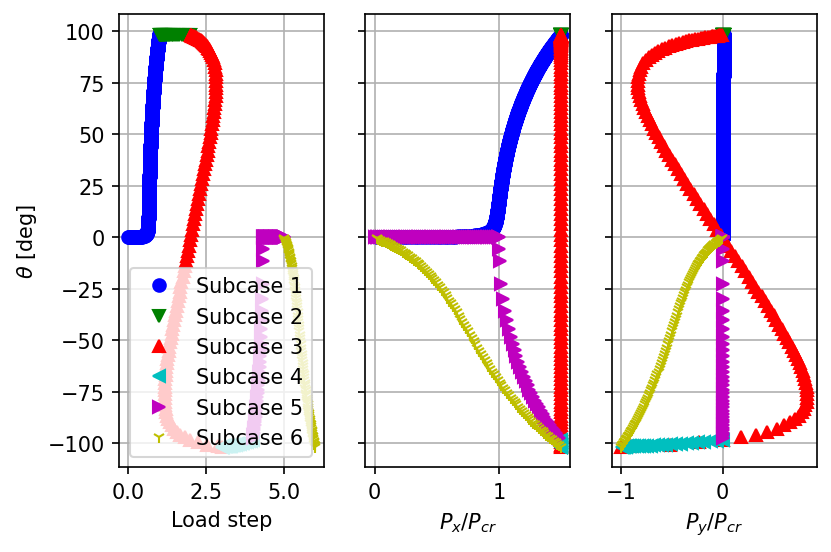

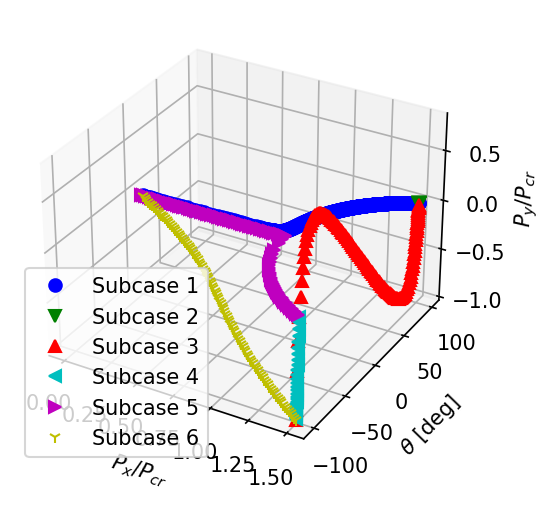

In [33]:
# Define model name
input_name = 'mixed_methods_PxPcr_1_5'
# Run analysis
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=alternative_subcases_input, bdf_filename=input_name)
# Read op2 file
op2_filepath = os.path.join(analysis_directory_path, input_name + '.op2')
op2_output = read_op2(op2_filename=op2_filepath, debug=False)
# Read load displacement history
load_steps, applied_loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=1)
# Plot equilibrium paths
plot_2d_equilibrium_paths(displacements, load_steps, applied_loads)
plot_3d_equilibrium_paths(displacements, applied_loads)

We can make the following observations.
* In subcase 1 the broken pitchfork is on the side corresponding to an upward deflection of the column, so in the same direction as the applied transverse load.
* Subcase 3 highlights the snap-through behavior of the column when the equilibrium point moves from one side to the other of the pitchfork.
* The rotation $\theta$ at the end of subcase 2 is equal and opposite to the one at the end of subcase 4.
* In subcase 5 the unbroken pitchfork is on the side corresponding to a downward deflection of the column, so in the same direction as the applied transverse load.
* In subcase 6 the broken pitchfork is again on the side corresponding to a downward deflection of the column, as the transverse force is applied in that direction. We can notice that the curve in the $P_x/P_{cr}$-$\theta$ plot is more distant from the bifurcation point with respect to the broken pitchfork curve described by subcase 1. This is caused by the different magnitude of the transverse load.
* The rotation $\theta$ at the end of subcase 3 is equal to the one at the end of subcase 6.

All these results are in line with the expectations.

## Conclusions <a name="conclusions"></a>
We can draw the following conclusions regarding the use of the arc-length method in Nastran.
* The order of subcases matters to get to a specific point of the equilibrium diagram.
* The arc-length method has issues when the subcase applies a load in the opposite direction with respect to the one of the previous subcase. In these situations, the Newton method should be used.

***

The cell below executes the style for this notebook. We use a slightly modified version of the custom style found on the GitHub of [barbagroup](https://github.com/barbagroup), [@LorenaABarba](https://twitter.com/LorenaABarba).

In [34]:
from IPython.core.display import HTML
def css_styling():
    styles = open(os.path.join(os.pardir, 'styles', 'custom.css'), 'r').read()
    return HTML(styles)
css_styling()